In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import sys
sys.path.insert(1, '../utils/')
import src_utils
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy

# 1. Set rcParams

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['axes.linewidth'] = 0.5

plt.rcParams["figure.dpi"] = 300

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

#perc_axes = 0.07409181787428054


# 2. Set up grid

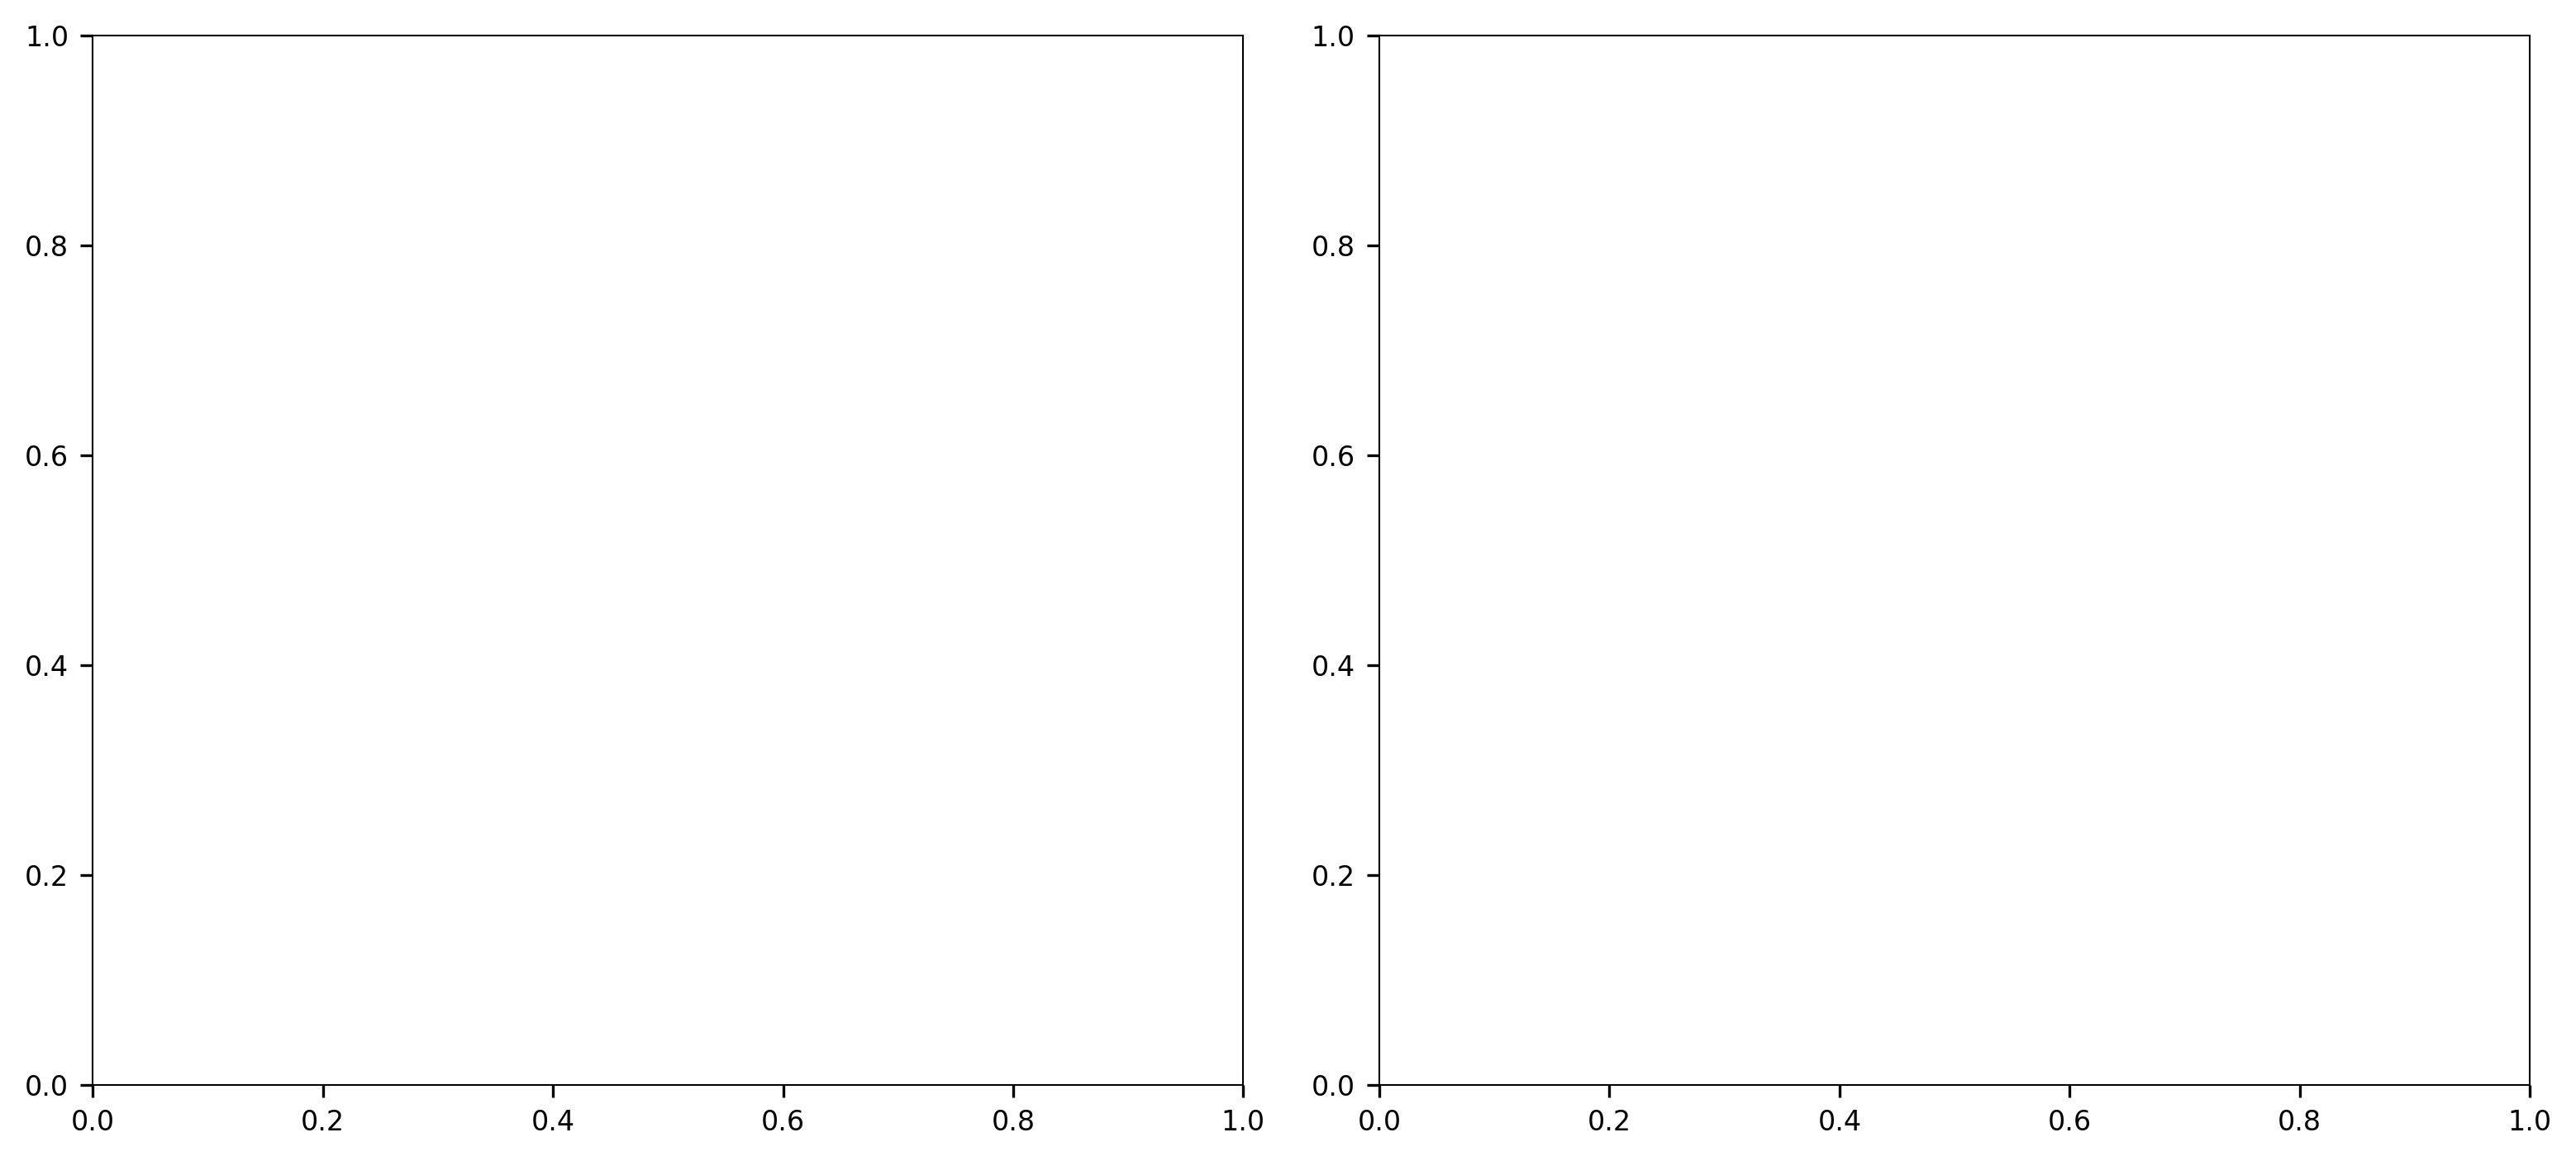

In [3]:
width = (174 / 25.4) * 1.5
height = 116 / 25.4 
fig = plt.figure(constrained_layout=True, figsize=(width, height))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

In [4]:
# Read in diffsel, dmso, and synon data

diffsel_df = pd.read_csv('../utils/diffsel_calib.csv', index_col=0)
positions = [np.nan, np.nan]
for mut in diffsel_df.index.tolist()[2:]:
    position = int(mut[1:-1])
    positions.append(position)
diffsel_df['position'] = positions

dmso_df = pd.read_csv('../utils/point_muts_calib.csv', index_col=0, header=[0,1])
dmso_df.rename(dict(zip(dmso_df.index.tolist(), diffsel_df.index.tolist())), inplace=True)

synon_zero_df = pd.read_csv('../utils/synon_df.csv', index_col=0, header=[0,1])

synon_diffsel = np.genfromtxt('../utils/synon_diffsel_calib.txt', delimiter=',')

# Define cutoffs for GOF activity and strong client

dmso_cutoff = np.nanmean(synon_zero_df.values) + 1.3 * np.nanstd(synon_zero_df.values)
diffsel_cutoff = np.nanmean(synon_diffsel) - 2 * np.nanstd(synon_diffsel)

In [5]:
# Read in ddG, SASA, and conservation DFs
# Open is 0, closed is 1
sasa_arr = np.genfromtxt('../utils/sc_sasa_arr.txt', delimiter=',')
sasa_df = pd.DataFrame(sasa_arr.T, index=diffsel_df.index.tolist(), columns=['closed','open'])

# hSASA
hsasa = pd.read_csv('../utils/hsasa_df.csv', index_col=0)

# Read in other Rosetta metrics
inactive_fl = pd.read_csv('../utils/prims_rosetta_XXX_2src_human_FL_gap-shifted.txt', skiprows=22, index_col=0, delimiter=' ')
inactive_cd = pd.read_csv('../utils/prims_rosetta_XXX_2src_human_CD_gap-shifted.txt', skiprows=22, index_col=0, delimiter=' ')
active_fl = pd.read_csv('../utils/prims_rosetta_XXX_1y57_human_FL_gap-shifted.txt', skiprows=22, index_col=0, delimiter=' ')
active_cd = pd.read_csv('../utils/prims_rosetta_XXX_1y57_human_CD_gap-shifted.txt', skiprows=22, index_col=0, delimiter=' ')


# Coevolution values
coevo_df = pd.read_csv('../utils/coevo_df.csv', index_col=0)


In [6]:
ax = ax1

idx = diffsel_df.index.tolist()

x = inactive_fl['norm_ddG'][idx].values
y = diffsel_df['diffsel'].values

client_mask = (diffsel_df['diffsel'] < diffsel_cutoff).values

ax.scatter(x[~client_mask], y[~client_mask], alpha=0.5, c='#b3b3b3')
ax.scatter(x[client_mask], y[client_mask], alpha=0.5, c='#b3b3b3')
ax.set_xlabel(r'$\Delta \Delta$G')
ax.set_ylabel('Client score')

mask = ~np.isnan(x)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ax.annotate('$r$={0:.2f}'.format(r_value), (xmin + 0.1, ymax - 0.5))

# Spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

/Users/vanessanguyen/.local/lib/python3.7/site-packages/pandas/core/series.py:1155: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [7]:
wt_hsasa = pd.read_csv('../utils/sc_hsasa_wt_df.csv', index_col=0)

In [8]:
dhsasa_closed = [np.nan, np.nan]
dhsasa_open = [np.nan, np.nan]

poses = wt_hsasa.index.tolist()
for var in hsasa.index.tolist()[2:]:
    pos = var[1:-1]
    
    for i, conf in enumerate(hsasa.columns.tolist()):
        dhsasa = hsasa.loc[var, conf] - wt_hsasa.loc[poses[i], pos]
        
        if i == 0:
            dhsasa_closed.append(dhsasa)
        else:
            dhsasa_open.append(dhsasa)

In [9]:
dhsasa_df = pd.DataFrame([dhsasa_closed, dhsasa_open], index=['closed', 'open'], columns=diffsel_df.index.tolist()).T

In [10]:
ax = ax2
idx = diffsel_df.index.tolist()

x = np.array(dhsasa_open)
y = diffsel_df['diffsel'].values
client_mask = y < diffsel_cutoff
ax.scatter(x[~client_mask], y[~client_mask], color='#b3b3b3', alpha=0.5)
ax.scatter(x[client_mask], y[client_mask], color='#b3b3b3', alpha=0.5)
#plt.scatter(x[client_mask], y[client_mask], label='Client')
#plt.title('open')
ax.set_xlabel(r'$\Delta$hSASA')
ax.set_ylabel('Client score')

mask = ~np.isnan(x)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ax.annotate('$r$={0:.2f}'.format(r_value), (xmin + 0.1, ymax - 0.5))

# Spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


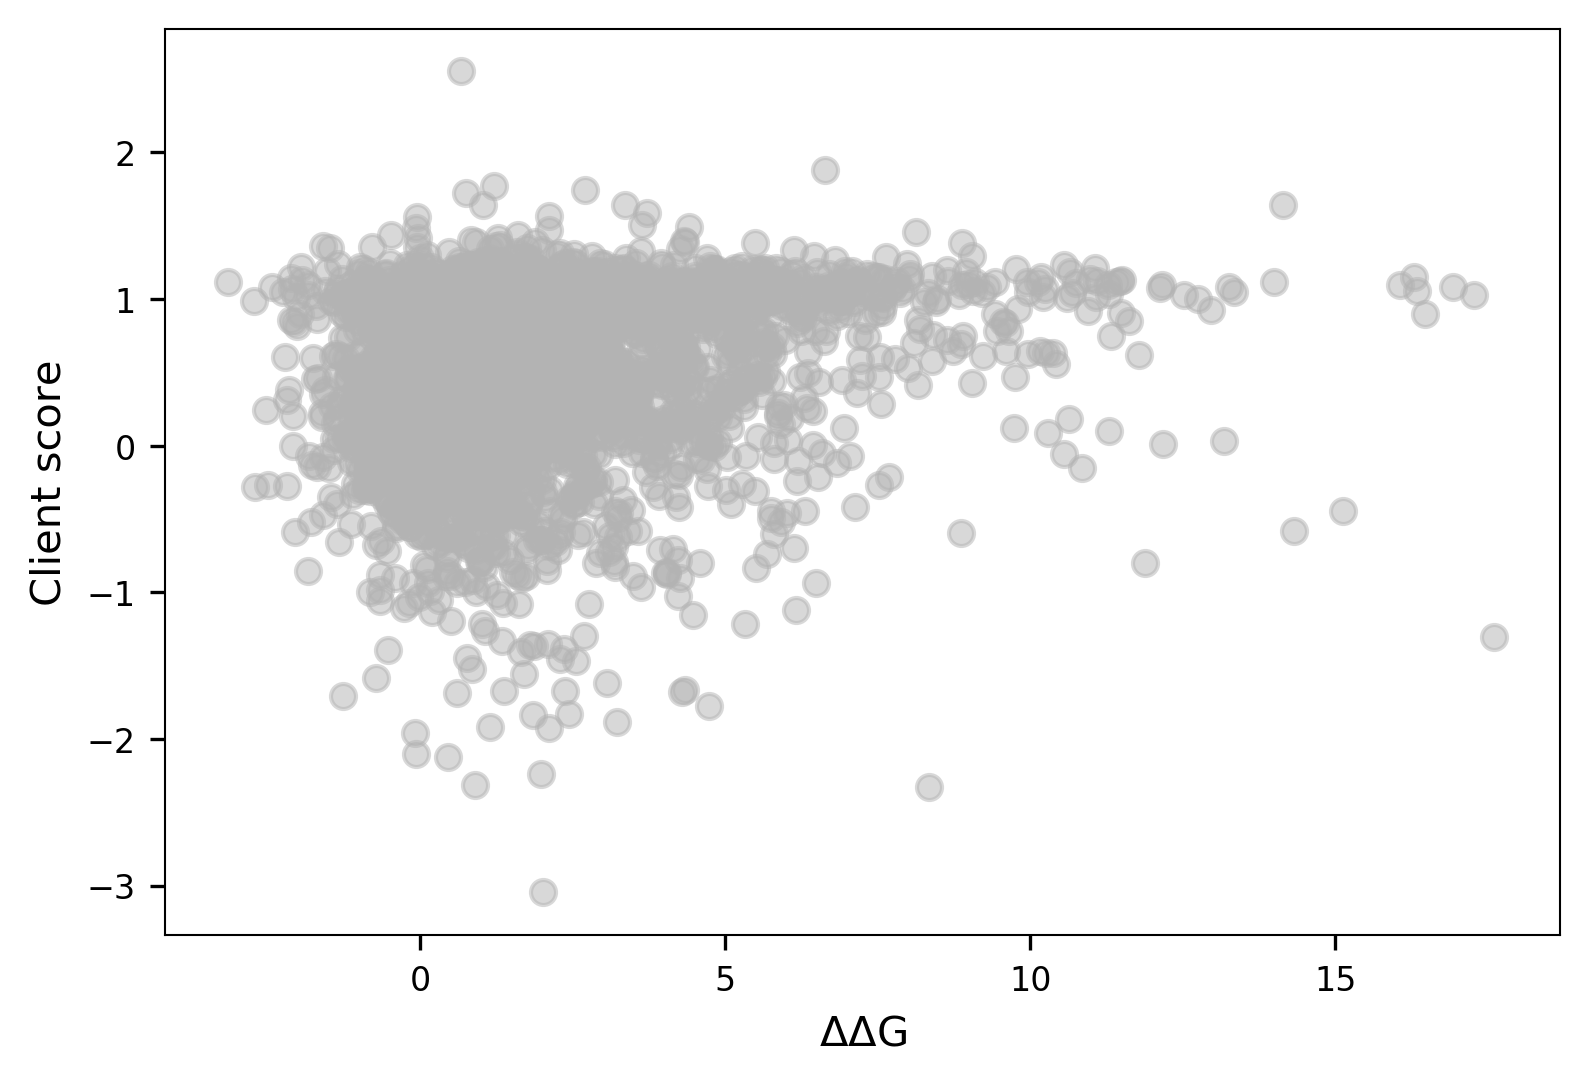

In [11]:


idx = diffsel_df.index.tolist()

x = inactive_fl['norm_ddG'][idx].values
y = diffsel_df['diffsel'].values

client_mask = (diffsel_df['diffsel'] < diffsel_cutoff).values

fig = plt.scatter(x[~client_mask], y[~client_mask], alpha=0.5, c='#b3b3b3')
plt.scatter(x[client_mask], y[client_mask], alpha=0.5, c='#b3b3b3')
plt.xlabel(r'$\Delta \Delta$G')
plt.ylabel('Client score')
plt.savefig('sf3b.png')

mask = ~np.isnan(x)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])

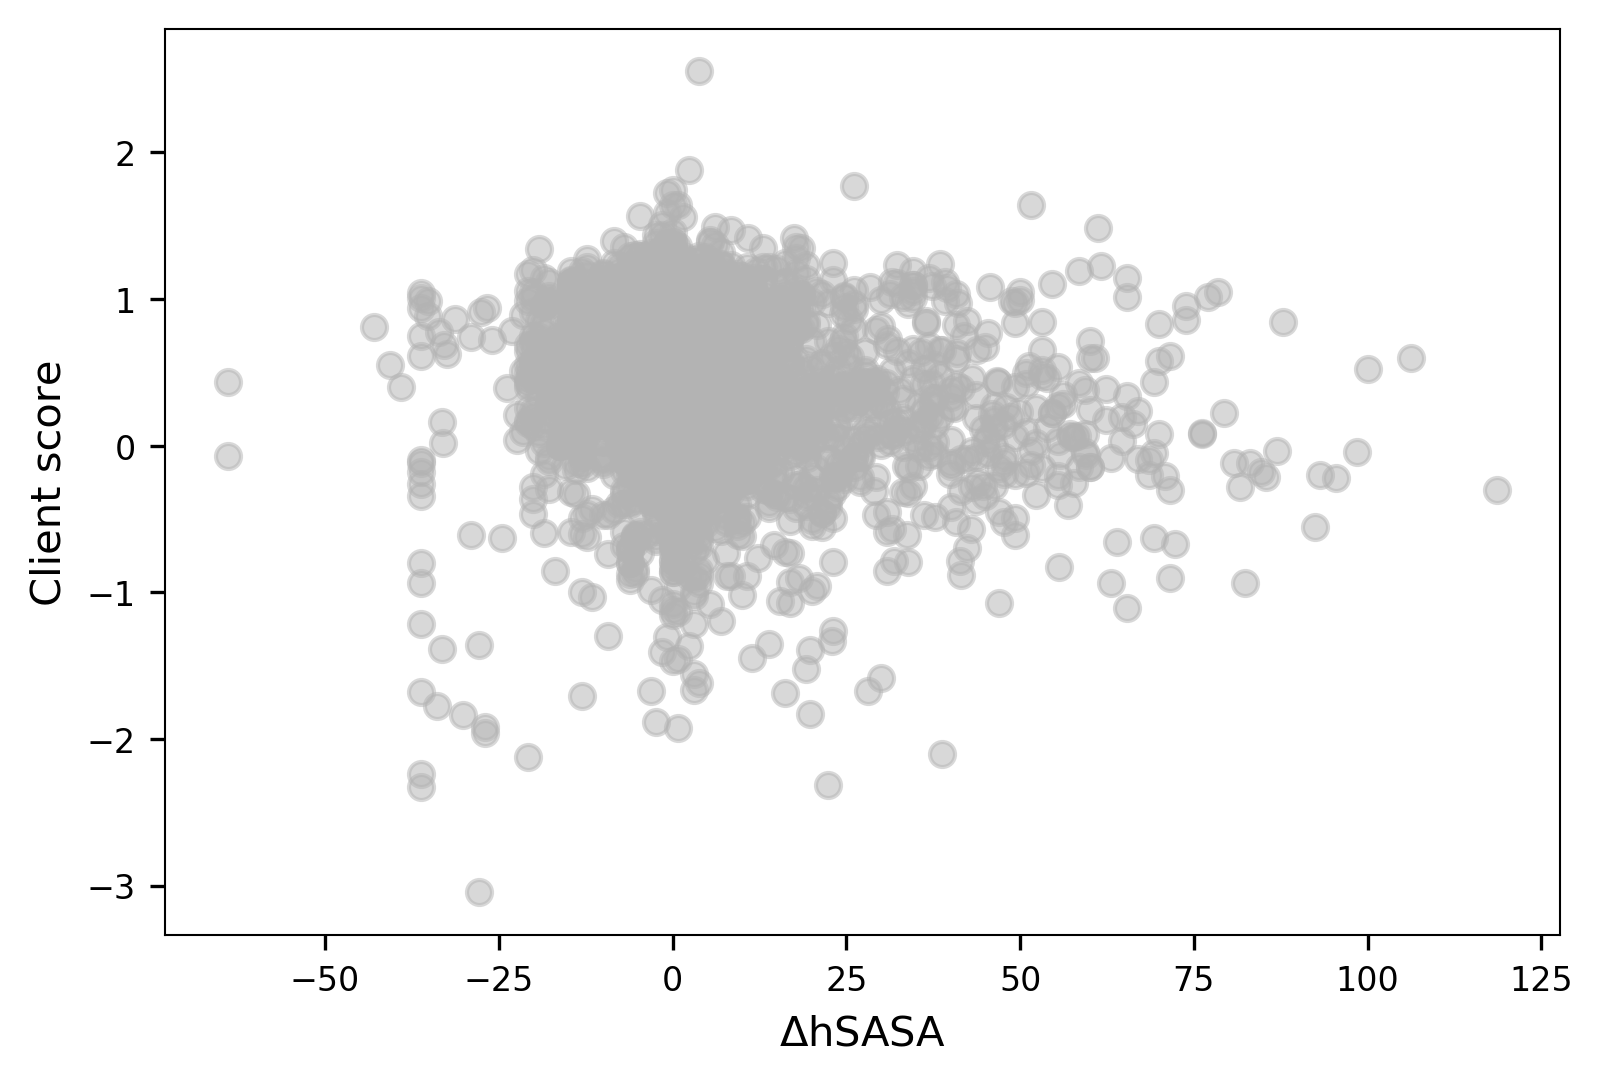

In [12]:
x = np.array(dhsasa_open)
y = diffsel_df['diffsel'].values
client_mask = y < diffsel_cutoff
plt.scatter(x[~client_mask], y[~client_mask], color='#b3b3b3', alpha=0.5)
plt.scatter(x[client_mask], y[client_mask], color='#b3b3b3', alpha=0.5)
plt.xlabel(r'$\Delta$hSASA')
plt.ylabel('Client score')

mask = ~np.isnan(x)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])
plt.savefig('sf4b.png')


In [13]:
variants = ['_wt', 'K298M', 'F512A', 'F512P', 'E381S']
variants = ['_wt', 'K298M'] + [
    'W289H',
    'T293D', 
    'G291L',
    'T443K',
    'F512A',
    'F512P',
    'R294T',
    'V274N',
    'E335M',
    'S333R',
    'P302Y',
    'E381S',
    'W285C',
    'V274C',
    'P506R',
    'W285M',
    'T299M'
]
client_scores = diffsel_df.loc[variants, 'diffsel']
activity_scores = dmso_df.loc[variants, ('Zero', 'score')]
ddgs = active_fl.loc[variants, 'norm_ddG']
dhsasas = dhsasa_df.loc[variants, 'open']
dhsasas[0] = 0
ddgs[0] = 0

y_arr = client_scores

/Users/vanessanguyen/.local/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [14]:
diffsel_cutoff

-0.8050240559227789

In [15]:
dhsasa_vars = ['E381K', 'T341I']
dhsasa = dhsasa_df.loc[dhsasa_vars, 'open']
client_scores = diffsel_df.loc[dhsasa_vars, 'diffsel']


x_arr = list(dhsasa)
y_arr = list(client_scores)

In [16]:
af_pocket_pos = [378, 381, 443, 444, 506, 508, 511, 512]
b1b2_pos = [273, 274, 275, 283, 285, 286]
sh2_pos = [325, 368, 375]
sh3_pos = [289, 290, 291, 293]

# Get client containing positions
diffsel_map = pd.read_csv('../utils/diffsel_calib_map.csv', index_col=0)
client_pos = diffsel_map.index[(np.sum(diffsel_map < diffsel_cutoff, axis=1) > 0).values].tolist()

# Average the ddG values at each client containing position
client_df_slice = (diffsel_df[diffsel_df['diffsel'] < diffsel_cutoff])

ave_ddgs = np.zeros(250)
for pos in client_pos:
    pos_df_slice = client_df_slice[client_df_slice['position'] == pos]
    pos_vars = pos_df_slice.index.tolist()
    idx = pos - 270
    ave_ddgs[idx] = np.mean(active_fl.loc[pos_vars, 'norm_ddG'])
#np.savetxt('ave_client_ddgs_zero_nonclient_pos.txt', ave_ddgs, delimiter='\n')

# Save as a numpy array to view
print('run ./scripts/loadBfacts.py')
print('run ./scripts/alphaToAll.py')
print('loadBfacts 2src_kinDom, startaa=270, source=ave_client_ddgs_zero_nonclient_pos.txt, set_colorbar=True')
print('cmd.cartoon("automatic")')
print('alphaToAll *, b')
print('spectrum b')

# Print out PyMOL commands, including greying out nonclient positions

run ./scripts/loadBfacts.py
run ./scripts/alphaToAll.py
loadBfacts 2src_kinDom, startaa=270, source=ave_client_ddgs_zero_nonclient_pos.txt, set_colorbar=True
cmd.cartoon("automatic")
alphaToAll *, b
spectrum b


In [17]:
print('run ./scripts/loadBfacts.py')
print('run ./scripts/alphaToAll.py')
print('loadBfacts 1y57_human_CD, startaa=270, source=ave_client_ddgs_zero_nonclient_pos.txt, set_colorbar=True')
print('cmd.cartoon("automatic")')
print('alphaToAll *, b')
print('spectrum b')


run ./scripts/loadBfacts.py
run ./scripts/alphaToAll.py
loadBfacts 1y57_human_CD, startaa=270, source=ave_client_ddgs_zero_nonclient_pos.txt, set_colorbar=True
cmd.cartoon("automatic")
alphaToAll *, b
spectrum b


In [18]:
print('run ./scripts/loadSpheres.py')
print('loadSpheres 1y57_human_CD, startaa=270, source=diffsel_sphere_count_size_2.txt')
print('select ca, 1y57_human_CD and n. CA')
print('show sphere, ca')

nonclient_pos = diffsel_map.index[(np.sum(diffsel_map < diffsel_cutoff, axis=1) == 0).values].tolist()
nonclient_pos_str = '+'.join([str(x) for x in nonclient_pos])
print('select nonclient_pos, resi ' + nonclient_pos_str)
#print('color gray70, nonclient_pos')
print('select obj1, 1y57_human_CD and resi 270-519')

run ./scripts/loadSpheres.py
loadSpheres 1y57_human_CD, startaa=270, source=diffsel_sphere_count_size_2.txt
select ca, 1y57_human_CD and n. CA
show sphere, ca
select nonclient_pos, resi 270+271+272+276+277+278+279+280+281+282+284+286+288+290+291+292+293+294+295+296+297+298+300+302+303+305+306+308+309+310+311+312+313+314+315+316+317+318+319+320+321+322+324+327+328+329+331+332+333+336+337+339+340+342+344+346+347+349+350+351+352+353+354+355+356+357+358+359+360+361+362+363+364+365+366+368+369+370+371+373+374+375+376+379+380+382+383+384+385+386+387+388+389+390+391+392+393+394+395+396+397+400+401+402+403+405+406+407+408+409+410+411+412+413+414+415+416+417+418+419+420+421+422+423+424+425+426+427+428+429+430+431+432+435+436+437+438+439+441+442+445+446+447+448+449+450+451+452+453+455+456+457+458+459+460+461+462+463+464+465+466+468+469+470+471+473+474+475+476+478+479+480+481+482+483+484+485+486+487+489+490+491+492+493+494+495+496+497+498+500+501+502+503+505+509+510+514+515+517+518+519
select obj

In [19]:
"""(-0.6769005060195923, 0.1745685338973999, 0.7150310277938843, 0.7326853275299072, 0.0673966258764267, 0.6771668195724487, 0.07002189010381699, 0.9822836518287659, -0.17353445291519165, 0.0, 0.0, -201.97518920898438, 10.812923431396484, 28.088464736938477, 31.98441505432129, -421.16986083984375, 825.1199951171875, -20.0)"""

'(-0.6769005060195923, 0.1745685338973999, 0.7150310277938843, 0.7326853275299072, 0.0673966258764267, 0.6771668195724487, 0.07002189010381699, 0.9822836518287659, -0.17353445291519165, 0.0, 0.0, -201.97518920898438, 10.812923431396484, 28.088464736938477, 31.98441505432129, -421.16986083984375, 825.1199951171875, -20.0)'

In [20]:
pos = np.arange(270,520)[ave_ddgs < np.percentile(ave_ddgs, 3)]
stab_pos = [str(x) for x in list(pos)]
print('select stabilizing_pos, resi ' + '+'.join(stab_pos))

select stabilizing_pos, resi 299+301+307+341+477+499+506+508


In [21]:
pos = np.arange(270,520)[ave_ddgs > np.percentile(ave_ddgs, 97)]
destab_pos = [str(x) for x in list(pos)]
print('select destabilizing_pos, resi ' + '+'.join(destab_pos))

select destabilizing_pos, resi 285+287+289+325+367+377+454+512


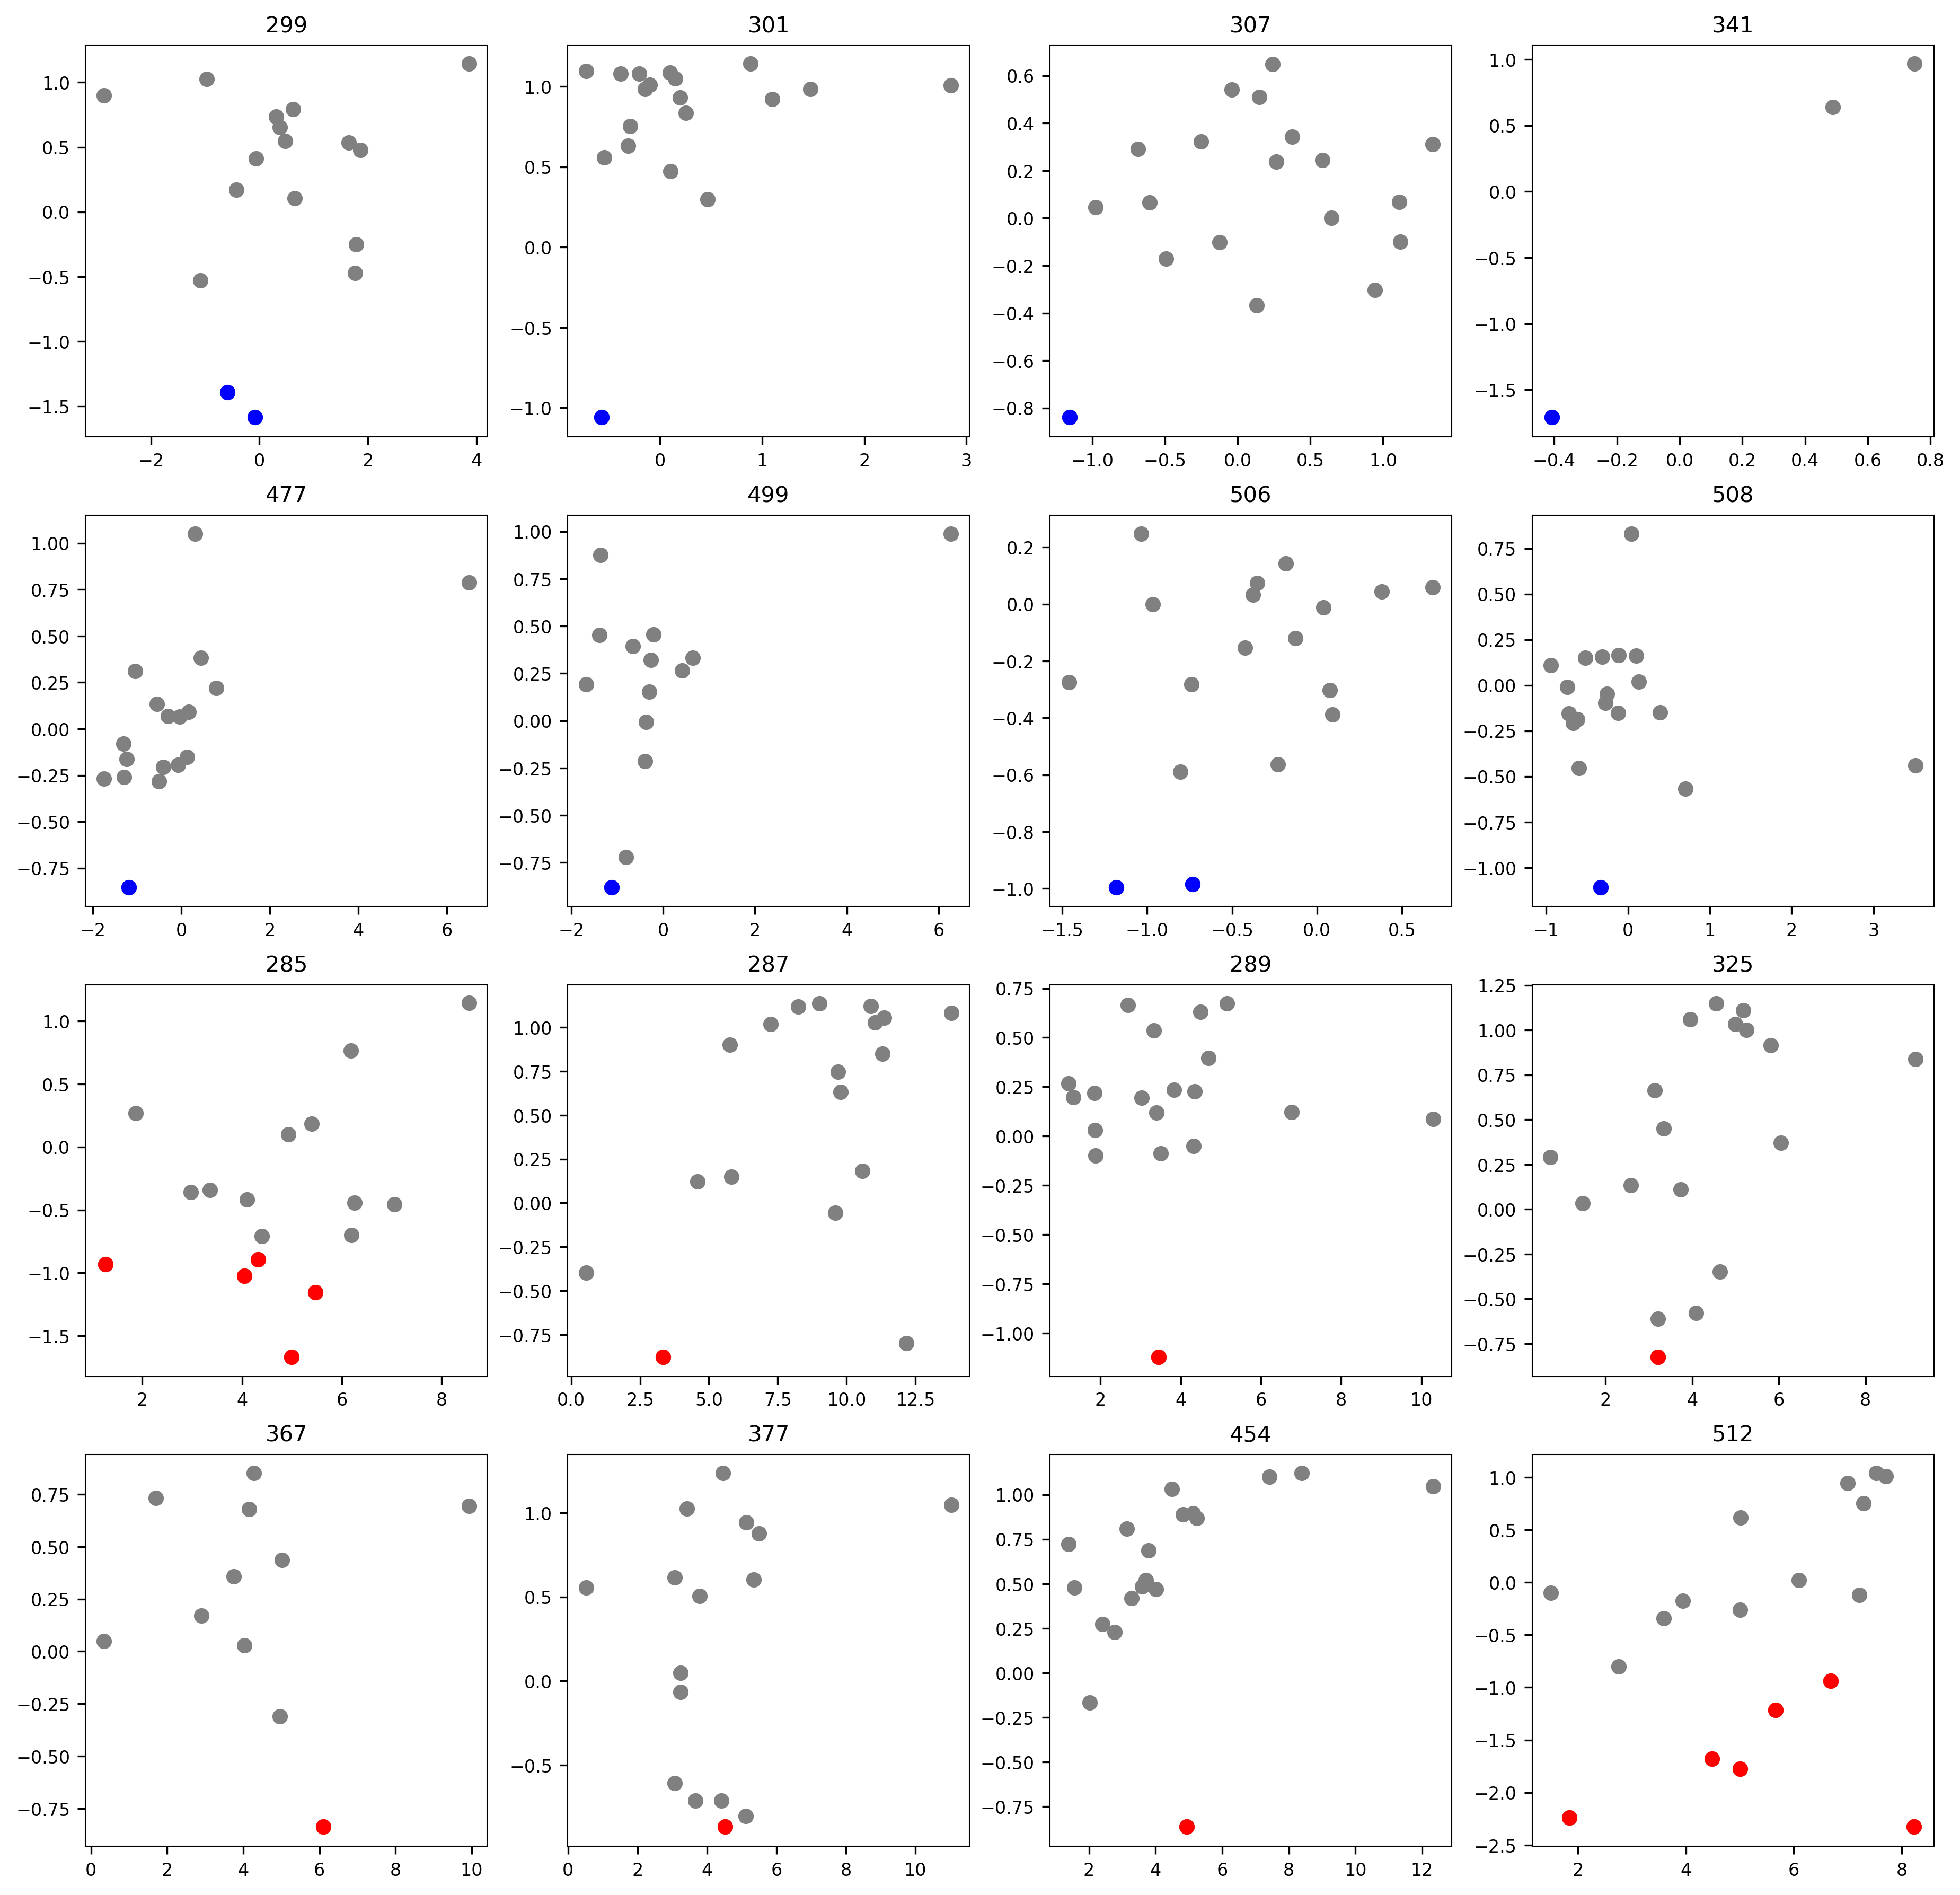

In [22]:
ddg_pos = stab_pos + destab_pos
ddg_pos = [int(x) for x in ddg_pos]
type_pos = (['stabilizing'] * len(stab_pos)) + (['destabilizing'] * len(destab_pos))
ddg_outlier_df = pd.DataFrame(type_pos, index=ddg_pos, columns=['Type'])

rs = []
fig, ax = plt.subplots(4, 4, figsize=(15,15))
for idx, pos in enumerate(ddg_outlier_df.index.tolist()):
    pos_idx = diffsel_df[diffsel_df['position'] == pos].index.tolist()
    x_arr = active_fl.loc[pos_idx, 'norm_ddG']    
    y_arr = diffsel_df.loc[pos_idx, 'diffsel']
    nanmask = ~np.isnan(x_arr)

    rs.append(scipy.stats.pearsonr(x_arr[nanmask], y_arr[nanmask])[0])
    client_mask = y_arr < diffsel_cutoff
    i = int(idx / 4)
    j = idx % 4
    ax[i, j].scatter(x_arr, y_arr, color='grey')
    
    if ddg_outlier_df.loc[pos, 'Type'] == 'stabilizing':
        co = 'b'
    else:
        co = 'r'
    ax[i, j].scatter(x_arr[client_mask], y_arr[client_mask], c=co)
    ax[i, j].set_title(pos)
    
ddg_outlier_df['pearson r'] = rs
fig.savefig('sf3c.png')

In [23]:
# dhSASA coloring

ave_dhsasa = np.zeros(250)
for pos in client_pos:
    pos_df_slice = client_df_slice[client_df_slice['position'] == pos]
    pos_vars = pos_df_slice.index.tolist()
    idx = pos - 270
    ave_dhsasa[idx] = np.mean(dhsasa_df.loc[pos_vars, 'open'])
#np.savetxt('ave_client_dhsasa_zero_nonclient_pos.txt', ave_dhsasa, delimiter='\n')

# Save as a numpy array to view
print('run ./scripts/loadBfacts.py')
print('run ./scripts/alphaToAll.py')
print('loadBfacts 1y57_human_CD, startaa=270, source=ave_client_dhsasa_zero_nonclient_pos.txt, set_colorbar=True')
print('cmd.cartoon("automatic")')
print('alphaToAll *, b')
print('spectrum b')

run ./scripts/loadBfacts.py
run ./scripts/alphaToAll.py
loadBfacts 1y57_human_CD, startaa=270, source=ave_client_dhsasa_zero_nonclient_pos.txt, set_colorbar=True
cmd.cartoon("automatic")
alphaToAll *, b
spectrum b


In [24]:
pos = np.arange(270,520)[ave_dhsasa < np.percentile(ave_dhsasa, 3)]
stab_pos = [str(x) for x in list(pos)]
print('select stabilizing_pos, resi ' + '+'.join(stab_pos))

select stabilizing_pos, resi 287+307+341+377+381+440+512+516


In [25]:
pos = np.arange(270,520)[ave_dhsasa > np.percentile(ave_dhsasa, 97)]
destab_pos = [str(x) for x in list(pos)]
print('select destabilizing_pos, resi ' + '+'.join(destab_pos))

select destabilizing_pos, resi 274+334+467+472+477+499+507+508


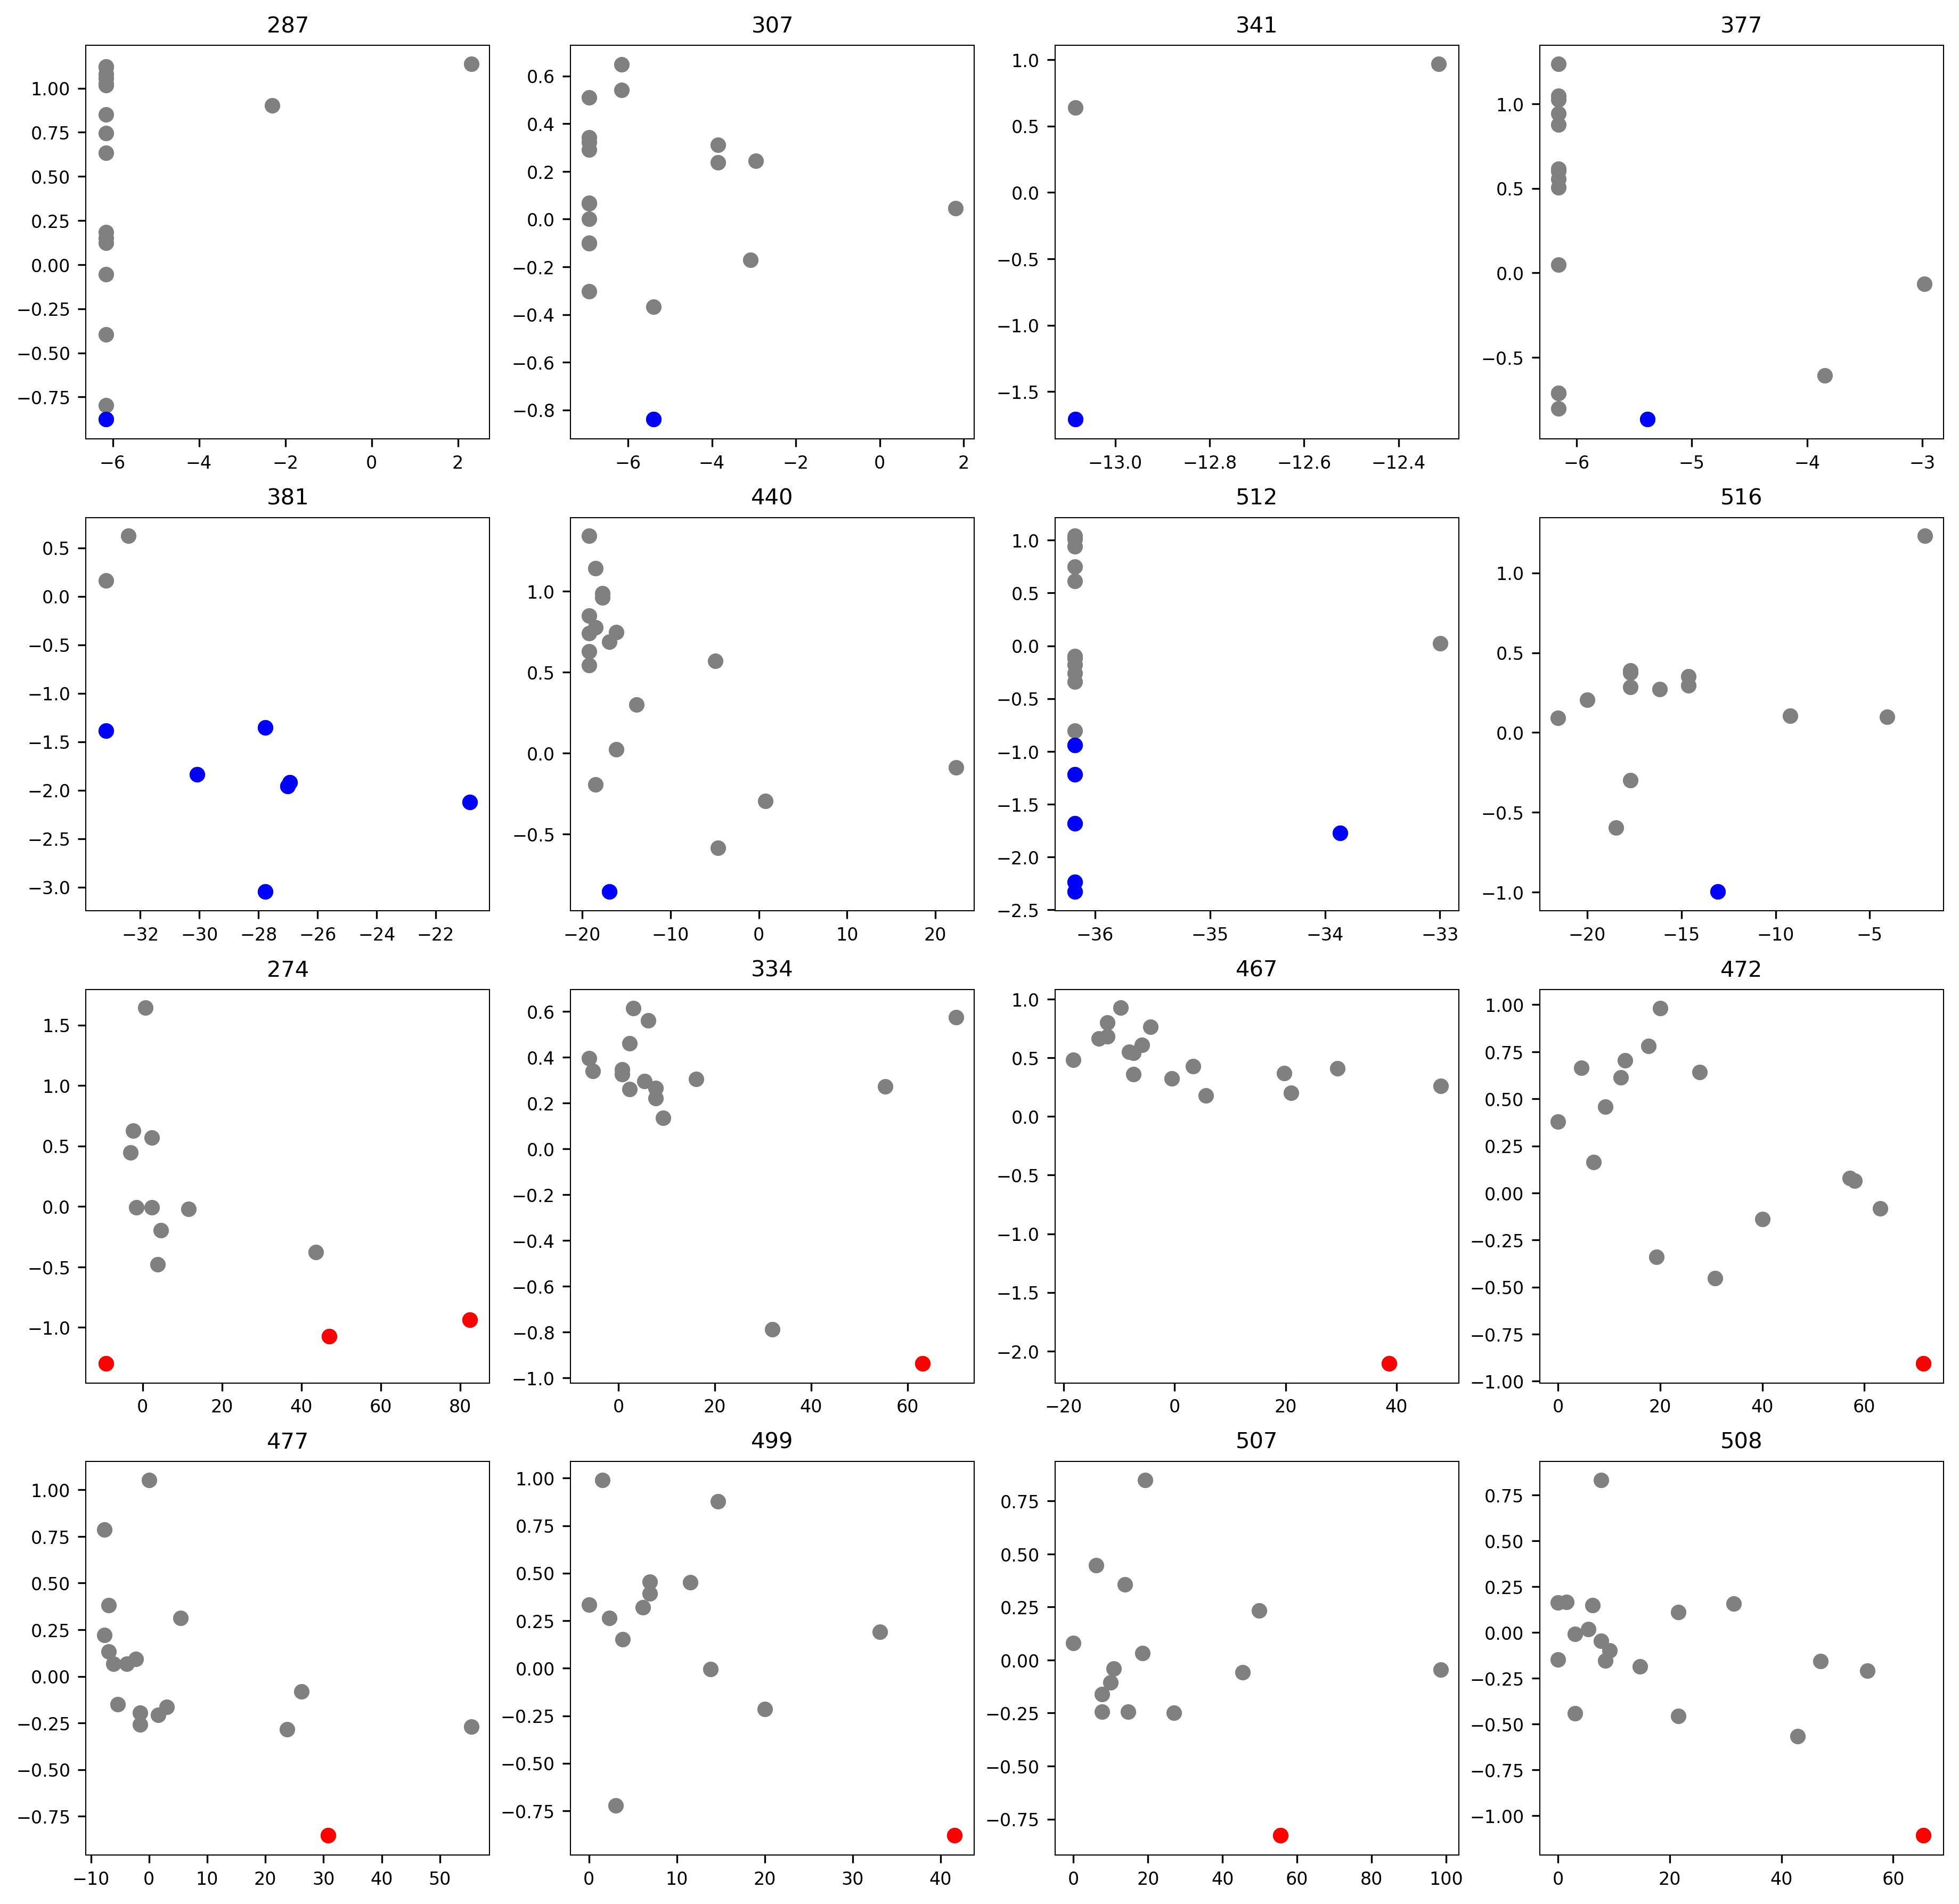

In [26]:
ddg_pos = stab_pos + destab_pos
ddg_pos = [int(x) for x in ddg_pos]
type_pos = (['Decrease'] * len(stab_pos)) + (['Increase'] * len(destab_pos))
dhsasa_outlier_df = pd.DataFrame(type_pos, index=ddg_pos, columns=['Type'])

rs = []
fig1, ax1 = plt.subplots(4, 4, figsize=(15,15))
for idx, pos in enumerate(dhsasa_outlier_df.index.tolist()):
    pos_idx = diffsel_df[diffsel_df['position'] == pos].index.tolist()
    x_arr = dhsasa_df.loc[pos_idx, 'open']    
    y_arr = diffsel_df.loc[pos_idx, 'diffsel']
    nanmask = ~np.isnan(x_arr)

    rs.append(scipy.stats.pearsonr(x_arr[nanmask], y_arr[nanmask])[0])
    client_mask = y_arr < diffsel_cutoff
    i = int(idx / 4)
    j = idx % 4
    ax1[i, j].scatter(x_arr, y_arr, color='grey')
    
    if dhsasa_outlier_df.loc[pos, 'Type'] == 'Decrease':
        co = 'b'
    else:
        co = 'r'
    ax1[i, j].scatter(x_arr[client_mask], y_arr[client_mask], c=co)
    ax1[i, j].set_title(pos)
    
dhsasa_outlier_df['pearson r'] = rs
fig1.savefig('sf4c.png')